# Chapter 1: Image Restoration and Inverse Problems in Image Processing

**Problems**

    1. Inverse Problems in Image Processing
    
    2. Denoising with Weighted Median Filtering

    3. Non-blind Deconvolution for Image Restoration    
        3.1: Deconvolution with Inverse Filter        
        3.2. Simulating the Bokeh Blur        
        3.3: Deconvolution with Wiener Filter with opencv-python        
        3.4: Deconvolution with (Unsupervised) Wiener Filter with scikit-image        
        3.5: Deconvolution with Richardson-Lucy algorithm        

    4. Blind Deconvolution with Richardson-Lucy

    5. Total Variation Denoising        
        5.1: TV Denoising with the Rudin, Fatemi and Osher algorithm proposed by Chambolle        
        5.2: TV Denoising with Chambolle vs. Bregman        
        
    6. Wavelet Denoising    
        6.1: Wavelet-denoising with pywt        
        6.2: Wavelet-denoising with scikit-image
        
    7. Non-local means Denoising
    
    8. Bilateral Denoising    
       8.1: with SimpleITK       
       8.2: with opencv-python
    
    9. Denoising with MAP Bayesian with an MRF Prior
  
    10. Denoising Images with Kernel PCA

### Problem 1: Inverse Problems in Image Processing

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.sparse.linalg import LinearOperator, gmres
from skimage.util import random_noise
from skimage.io import imread
from skimage.color import rgb2gray
import cv2
import warnings
warnings.filterwarnings('ignore') # ignore warnings

In [10]:
def A(f, sigma):
    return gaussian_filter(f, sigma)

def degrade(f, sigma, theta):
    g = A(f, sigma) 
    g += theta*np.random.randn(g.shape[0], g.shape[1])
    return g
    
sigma, theta = 0.15, 0.075
im = rgb2gray(imread('images/Img_01_17.jpg'))
f_true = im
g = degrade(f_true, sigma, theta)

In [11]:
def ATA(f, alpha=1e-2):
    y = A(f, sigma)
    z = A(y, sigma) + alpha*f
    return z

h, w = g.shape
AL = LinearOperator((w*h,w*h), ATA)
ATg = np.ravel(A(g, sigma))
f_hat = np.reshape(gmres(AL, ATg)[0], (h,w))

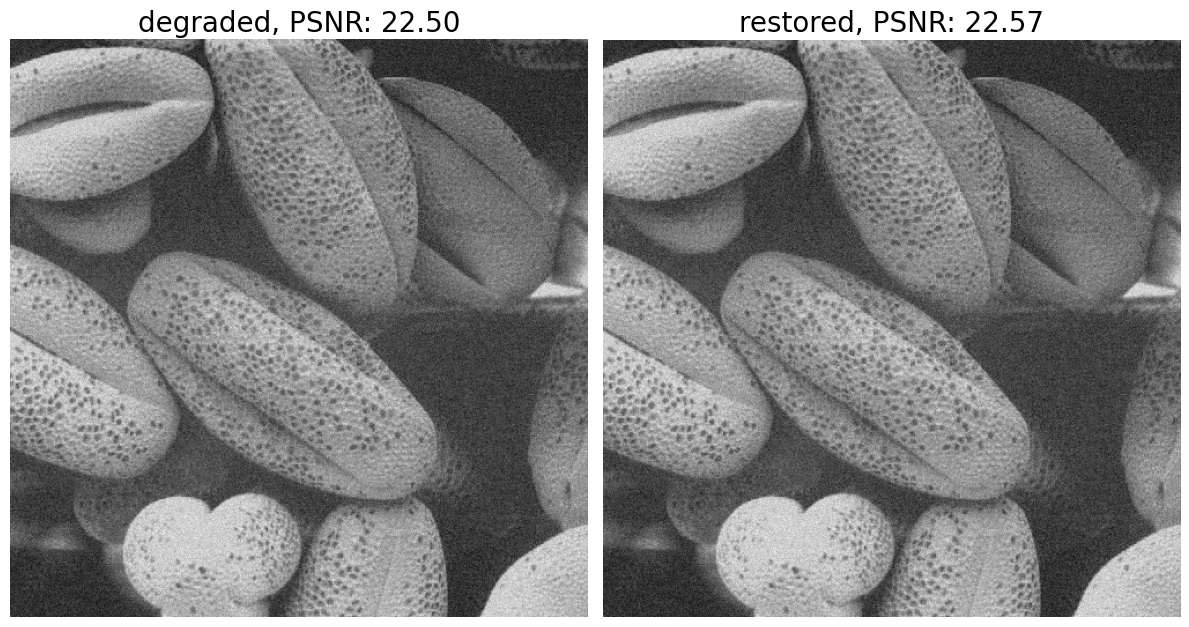

In [15]:
plt.figure(figsize=(12,8))
plt.gray()
plt.subplot(121), plt.imshow(g), plt.title('degraded, PSNR: {:.02f}'.format(psnr(f_true, g)), size=20), plt.axis('off')
plt.subplot(122), plt.imshow(f_hat), plt.title('restored, PSNR: {:.02f}'.format(psnr(f_true, f_hat)), size=20), plt.axis('off')
plt.tight_layout()
plt.show()

### Problem 2: Denoising with Weighted Median Filtering

In [27]:
import cv2
from skimage.util import random_noise

In [19]:
def weighted_median(im, mask):
    h, w = im.shape
    sz = mask.shape[0]
    im1 = im.copy()
    mask1 = mask.ravel()
    for i in range(h-sz+1):
        for j in range(w-sz+1):
            win = im[i:i+sz, j:j+sz].ravel()
            indices = np.argsort(win)[::-1]
            win, mask1 = win[indices], mask1[indices]
            csum1, csum2 = np.cumsum(mask1), np.cumsum(mask1[::-1])[::-1]
            k = 0
            while csum1[:k].sum() < csum2[k:].sum():
                k += 1
            im1[i+sz//2, j+sz//2] = win[k]
    return im1

In [22]:
im = cv2.imread('images/Img_01_00.jpg', 0)
im = im / im.max()
noisy_im = random_noise(im, mode='s&p')
weight_mask = np.ones((5,5))
weight_mask[1:-1,1:-1] = 2
denoised_im = weighted_median(noisy_im, weight_mask)

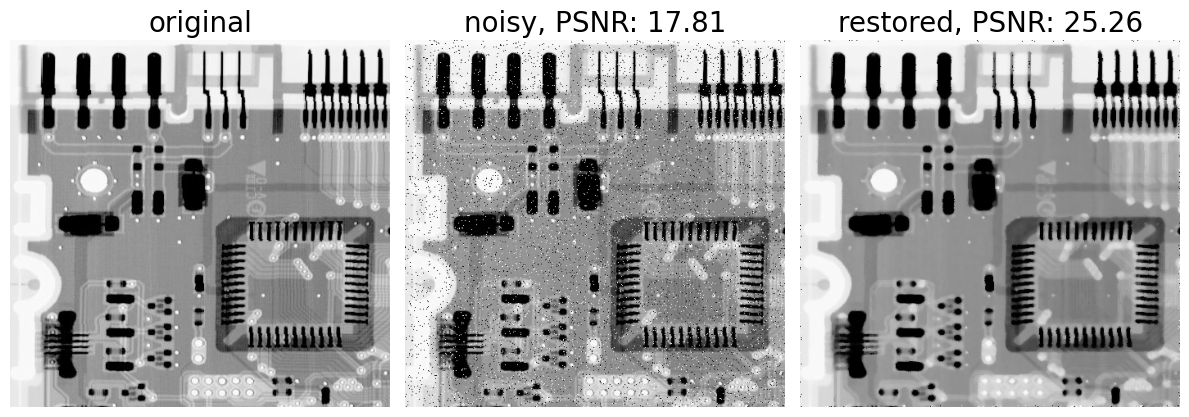

In [23]:
plt.figure(figsize=(12,8))
plt.gray()
plt.subplot(131), plt.imshow(im), plt.title('original', size=20), plt.axis('off')
plt.subplot(132), plt.imshow(noisy_im), plt.title('noisy, PSNR: {:.02f}'.format(psnr(im, noisy_im)), size=20), plt.axis('off')
plt.subplot(133), plt.imshow(denoised_im), plt.title('restored, PSNR: {:.02f}'.format(psnr(im, denoised_im)), size=20), plt.axis('off')
plt.tight_layout()
plt.show()

![](images/denoised_WMF.png)

### Problem 3: Non-blind Deconvolution for Image Restoration

**Deconvolution** is the operation which is inverse to **convolution**, it is a computationally intensive image processing technique for image restoration. In general, the objective of deconvolution is to find an (approximate) solution for $f$ from a convolution equation of the form: $g = f \circledast h + \epsilon$, given $g$ and the convolution *kernel* $h$. In this section, we shall discuss on a few deconvolution algorithms with the assumption that the deconvolution is **non-blind**, i.e., the *point-spread function* (*PSF*) or the *kernel* $h(.)$ is **known**.

### 3.1: Image Deconvolution with Inverse Filter

In [24]:
from scipy import signal
import scipy.fftpack as fp
from skimage.io import imread
from skimage.color import rgb2gray
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [25]:
def convolve2d(im, psf, k):
    M, N = im.shape
    freq = fp.fft2(im)
    assert(k % 2 == 1 and k > 0 and k <= min(M,N)) # assumption: min(M,N) >= k > 0, k odd, kxk kernel
    psf = np.pad(psf, (((M-k)//2,(M-k)//2+(1-M%2)), ((N-k)//2,(N-k)//2+(1-N%2))), mode='constant') 
    freq_kernel = fp.fft2(fp.ifftshift(psf))
    return np.abs(fp.ifft2(freq*freq_kernel))

def inverse_filter_cutoff(y, h, eta):
    Hf = fp.fft2(fp.ifftshift(h))
    M, N = Hf.shape
    u, v = np.meshgrid(range(N), range(M))
    indices = np.sqrt(u**2 + v**2) <= eta
    Hf[indices] = np.ones((M,N))[indices] / Hf[indices]
    Hf[np.sqrt(u**2 + v**2) > eta] = 0
    Yf = fp.fft2(y)
    I = Yf*Hf 
    im = np.abs(fp.ifft2(I))
    return im, Hf

def pseudo_inverse_filter(y, h, epsilon):
    Hf = fp.fft2(fp.ifftshift(h))
    M, N = Hf.shape
    Hf[(np.abs(Hf)<epsilon)] = 0
    indices = np.where((np.abs(Hf)>=epsilon))
    Hf[indices] = np.ones((M,N))[indices] / Hf[indices]
    Yf = fp.fft2(y)
    I = Yf*Hf 
    im = np.abs(fp.ifft2(I))
    return im, Hf

In [26]:
def plot_freq_filter(F, title, size=20):
    plt.imshow(20*np.log10( 0.01 + np.abs(fp.fftshift(F))), cmap='inferno'), plt.title(title, size=size), plt.colorbar()

def plot_freq_spec_3d(freq):
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    Y = np.arange(-freq.shape[0]//2,freq.shape[0]-freq.shape[0]//2)
    X = np.arange(-freq.shape[1]//2,freq.shape[1]-freq.shape[1]//2)
    X, Y = np.meshgrid(X, Y)
    Z = (20*np.log10(0.01 + fp.fftshift(freq))).real
    surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.inferno, linewidth=0, antialiased=True)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    plt.show()

#### Gaussian Blur Kernel

In [29]:
im = rgb2gray(imread('images/Img_01_13.jpg')) 
(M, N), k, sigma2, nsigma2 = im.shape, 15, 0.125, 0.0025
kernel = np.outer(signal.windows.gaussian(k, sigma2), signal.windows.gaussian(k, sigma2))
im_blur = convolve2d(im, kernel, k) #, mode='same')
im_cor = random_noise(im_blur, var=nsigma2)
freq = fp.fft2(im_cor)
epsilon = 1e-3
eta = 1 / epsilon
kernel = np.pad(kernel, (((M-k)//2,(M-k)//2+1), ((N-k)//2,(N-k)//2+1)), mode='constant')
im_res_cutoff, F_cutoff = inverse_filter_cutoff(im_cor, kernel, eta)
im_res_pseudo, F_pseudo = pseudo_inverse_filter(im_cor, kernel, epsilon)

![](images/inv_out.png)

![](images/fft_gauss_out.png)

#### Motion Blur Kernel

In [ ]:
im = rgb2gray(imread('images/Img_01_05.jpg')) 
(M, N), k = im.shape, 21 # a 21 x 21 motion blurred kernel
kernel = np.zeros((k, k))
kernel[int((k-1)/2), :] = np.ones(k)
kernel = kernel / k
im_blur = convolve2d(im, kernel, k) #, mode='same')
im_cor = im_blur
freq = fp.fft2(im_cor)
kernel = np.pad(kernel, (((M-k)//2,(M-k)//2+1), ((N-k)//2,(N-k)//2+1)), mode='constant')
epsilon = 10e-3
im_res_pseudo, F_pseudo = pseudo_inverse_filter(im_cor, kernel, epsilon)

![](images/motion_blur_out.png)

![](images/fft_motion_out.png)

### 3.2. Simulating the Bokeh Blur

In [ ]:
from skimage.color import rgb2gray, rgba2rgb

In [ ]:
def func(x):
    return x**3

def apply_bokeh_blur(img, mask):
    h, w = mask.shape
    out = np.zeros(img.shape)
    total = 0
    for i in range(h): 
        for j in range(w): 
            if mask[i, j] != 0: 
                out += mask[i, j] * func(np.roll(img, (i,j), (0,1)))
                total += mask[i, j]
    out /= total
    out /= out.max()
    return out

In [ ]:
mask = rgb2gray(rgba2rgb(imread('images/Img_01_12.png')))
img = cv2.resize(imread('images/Img_01_13.png') / 255, mask.shape[::-1])
out = apply_bokeh_blur(img, mask)

Plot the input image and the output image with Bokeh blur. Create visually interesting results by varying the shape of the mask (e.g., use hexagonal mask instead), you should get a figuure like the following one.

![](images/bokeh_out.png)

### 3.3: Wiener deconvolution with opencv-python

In [ ]:
def blur_edge(img, d=31):
    h, w  = img.shape[:2]
    img_pad = cv2.copyMakeBorder(img, d, d, d, d, cv2.BORDER_WRAP)
    img_blur = cv2.GaussianBlur(img_pad, (2*d+1, 2*d+1), -1)[d:-d,d:-d]
    y, x = np.indices((h, w))
    dist = np.dstack([x, w-x-1, y, h-y-1]).min(-1)
    w = np.minimum(np.float32(dist)/d, 1.0)
    return img*w + img_blur*(1-w)

def motion_kernel(angle, d, sz=63):
    kern = np.ones((1, d), np.float32)
    c, s = np.cos(angle), np.sin(angle)
    A = np.float32([[c, -s, 0], [s, c, 0]])
    sz2 = sz // 2
    A[:,2] = (sz2, sz2) - np.dot(A[:,:2], ((d-1)*0.5, 0))
    kern = cv2.warpAffine(kern, A, (sz, sz), flags=cv2.INTER_CUBIC)
    return kern

def defocus_kernel(d, sz=63):
    kern = np.zeros((sz, sz), np.uint8)
    cv2.circle(kern, (sz, sz), d, 255, -1, cv2.LINE_AA, shift=1)
    kern = np.float32(kern) / 255
    return kern

def deconvolve(img, kern):
    kern /= kern.sum()
    kern_pad = np.zeros_like(img)
    kh, kw = kern.shape
    kern_pad[:kh, :kw] = kern
    freq = cv2.dft(img, flags=cv2.DFT_COMPLEX_OUTPUT)
    kern_freq = cv2.dft(kern_pad, flags=cv2.DFT_COMPLEX_OUTPUT, nonzeroRows = kh)
    kern_freq2 = (kern_freq**2).sum(-1)
    kern_wiener = kern_freq / (kern_freq2 + noise)[...,np.newaxis]
    res = cv2.mulSpectrums(freq, kern_wiener, 0)
    res = cv2.idft(res, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)
    res = np.roll(res, -kh//2, 0)
    res = np.roll(res, -kw//2, 1)
    return res

In [ ]:
img = cv2.imread('images/Img_01_03.jpg', cv2.IMREAD_GRAYSCALE)
img = np.float32(img) / 255
img = blur_edge(img)
angle, d, snr = np.deg2rad(135), 22, 25
noise = 10**(-0.1*snr)

In [ ]:
kern_defocus = defocus_kernel(d)
img_defocussed = cv2.filter2D(img,-1,kern_defocus)
res_defocussed = deconvolve(img_defocussed, kern_defocus)

In [ ]:
kern_blur = motion_kernel(angle, d)
img_blur = cv2.filter2D(img,-1,kern_blur)  # apply motion blur
res_blur = deconvolve(img_blur, kern_blur)

Plot the original image, the *kernels*, the *defocussed* / *blurred* images and *restored* images, you should get figures like the following ones:

![](images/deconvolve_in.png)
![](images/deconvolve_out.png)

### 3.4: Deconvolution with (Unsupervised) Weiner Filter with scikit-image

In [ ]:
from skimage import color, restoration
from scipy.signal import convolve2d as conv2

In [ ]:
im = rgb2gray(imread('images/Img_01_01.jpg'))
noisy = im.copy()
psf = np.ones((5, 5)) / 25
noisy = conv2(noisy, psf, 'same')
noisy += 0.1 * im.std() * np.random.standard_normal(im.shape)

In [ ]:
deconvolved_unsup, _ = restoration.unsupervised_wiener(noisy, psf)
deconvolved = scipy.signal.wiener(noisy, (5,5))

![](images/weiner_out.png)

### 3.5: Non-Blind Deconvolution with Richardson-Lucy algorithm 

The *Richardson–Lucy* algorithm, also known as Lucy–Richardson deconvolution [9], is an iterative procedure for recovering an underlying image that has been blurred by a **known** point spread function. It's an iterative **Bayesian** algorithm for *image restoration*. The iterative updation step of the algorithm is shown in the following figure:

![](images/Img_01_32.png)


Here, since the PSF $g(x)$ is known, we can find the restored $f(x)$ by iterating over the above equation until convergence. An initial guess is required for the restored $f_0(x)$ to start the algorithm. Then, in subsequent iterations, because of the form of the algorithm, large deviations in the guess from the true object are lost rapidly in initial iterations, whereas detail is added more slowly in subsequent iterations. Advantages of this algorithm include a nonnegativity constraint if the initial guess
$f_0(x) \geq 0$. Also, energy is conserved as the iteration proceeds.

In this example, we shall deconvolve an image using Richardson-Lucy deconvolution algorithm, using `skimage.restoration` module's implementation. The algorithm is based on a *PSF* which is described as the *impulse response* of the optical system. The blurred image is sharpened through a number of iterations, which needs to be hand-tuned.

* Read the input cameraman image, convert it to grayscale. Use a $5\times 5$ box kernel to convolve / blur the image and add random Poisson noise to the image of rate $\lambda$, using the `np.random.poisson()` function, as shown in the following code snippet.

In [ ]:
im = color.rgb2gray(imread('images/Img_01_01.jpg'))
im_noisy = im.copy()
psf = np.ones((5, 5)) / 25
im_noisy = conv2(im_noisy, psf, 'same')
im_noisy += (np.random.poisson(lam=25, size=im.shape) - 10) / 255.

In [ ]:
deconvolved_RL = restoration.richardson_lucy(im_noisy, psf, iterations=20)

Plot the restored images for different iterations, along with the input and noisy image. You should get a figure like the following one:

![](images/rl_out.png)

### Problem 4: Blind Deconvolution with Richardson-Lucy

In [ ]:
from scipy.signal import convolve2d, fftconvolve
from skimage import img_as_float

In [ ]:
def norm(im):
    return im - im.min() / (im.max() - im.min())

def richardson_lucy_blind(image, psf, original, num_iter=5):    
    im_deconv = np.full(image.shape, 0.1, dtype='float')   #image.copy() 
    for i in range(num_iter):
        psf_mirror = np.flip(psf)
        conv = fftconvolve(im_deconv, psf, mode='same')
        relative_blur = image / (conv + 0.001)
        im_deconv *= fftconvolve(relative_blur, psf_mirror, mode='same')
        im_deconv_mirror = np.flip(im_deconv)
        psf *= fftconvolve(relative_blur, im_deconv_mirror, mode='same')
        # plot the original and restored images along with the estimated blur PSF here
    return norm(im_deconv), psf

In [ ]:
img = img_as_float(imread('images/Img_01_09.jpg', True))
original, k = img.copy(), 7
psf = np.ones((k, k)) / k**2
img = convolve2d(img, psf, 'same')
img += 0.3 * img.std() * np.random.default_rng().standard_normal(img.shape)

In [ ]:
psf = np.random.random((k, k))
psf /= np.sum(psf) 
psf = np.pad(psf, (((M-k)//2,(M-k)//2+(1-M%2)), ((N-k)//2,(N-k)//2+(1-N%2))), mode='constant') 
deconvolved = richardson_lucy_blind(img, psf, original, 3)  

* Plot the *restored* image (compute the *PSNR*) along with the estimated *PSF* for the first couple of iterations, you should obtain a figure like the one shown below:

![](images/rlb_out.png)

### Problem 5: Total Variation Denoising

### 5.1: TV Denoising with the Rudin, Fatemi and Osher algorithm proposed by Chambolle 

Total variation (TV) regularization is a technique that was originally developed for *additive white Gaussian noise* (**AWGN**)
image denoising by Rudin, Osher, and Fatemi. They proposed to estimate the denoised image u as the solution of a minimization problem:

![](images/Img_01_24.png)

where $\lambda$ is a positive parameter, here the first term is for regulariation and the second term represents the data fidelity term, which depends on the noise model. This $\mathbb{l}_2$-$TV$ problem is referred to as the *Rudin-Osher-Fatemi* or *ROF* problem. 

* Denoising is performed as an infinite-dimensional **minimization** problem, where the search space is all bounded variation (BV) images.  ${\textstyle \operatorname {BV} (\Omega )}$ refers the family of functions (with bounded variation) over the domain ${\displaystyle \Omega }$, ${\textstyle \operatorname {TV} (\Omega )}$ is the total variation over the domain, and ${\textstyle \lambda }$ is a penalty term. When ${\textstyle u}$ is *smooth*, the *total variation* is equivalent to the integral of the gradient magnitude:

   ![](images/Img_01_25.png)

  ${\textstyle \|\cdot \|}$ is the Euclidean norm. Then the objective function of the minimization problem becomes:

   ![](images/Img_01_26.png)

* Using the *Euler-Lagrange equation* for *minimization* of the above *functional* [6] results in the following *partial differential equation* (**PDE**):


   ![](images/Img_01_27.png)

* Here is the time-dependent version of the **ROF** equation:

   ![](images/Img_01_28.png)

* In this problem, we shall denoise an image with `scikit-image`'s implementation of TV denoising, using the algorithm proposed by **Chambolle**, as shown in the following figure. 

   ![](images/Img_01_29.png)

* Total variation denoising tries to minimize the total variation of an image (which is roughly equuivalent to the integral of norm of image gradient) and often produces *cartoon-like* (*piecewise-constant*) images.

* Let's start by importing the required libraries, using the following ode snippet. Notice that the version of the `scikit-image` library must be $\geq 0.14$.

In [7]:
import skimage
print(skimage.__version__) # should be >= 0.14
from skimage.restoration import denoise_tv_chambolle

0.17.2


In [ ]:
im = 255*rgb2gray(imread('images/Img_01_01.jpg'))
noisy = im + np.random.normal(loc=0, scale=im.std() / 4, size=im.shape)

In [ ]:
for weight in [10, 25, 50, 100]:
    tv_denoised = denoise_tv_chambolle(noisy, weight=weight)

![](images/tv_out.png)

As can be seen from the above figures, as we go on increasing the weights, we get more denoising effect, at the cost of fidelity to the input image (e.g., texture flattening).

### 5.2: TV Denoising with Chambolle vs. Bregman

In [6]:
from skimage.restoration import denoise_tv_chambolle, denoise_tv_bregman

In [ ]:
img = img_as_float(imread('images/Img_01_30.png'))
noisy = random_noise(img, var=0.02)
noisy = np.clip(noisy, 0, 1)

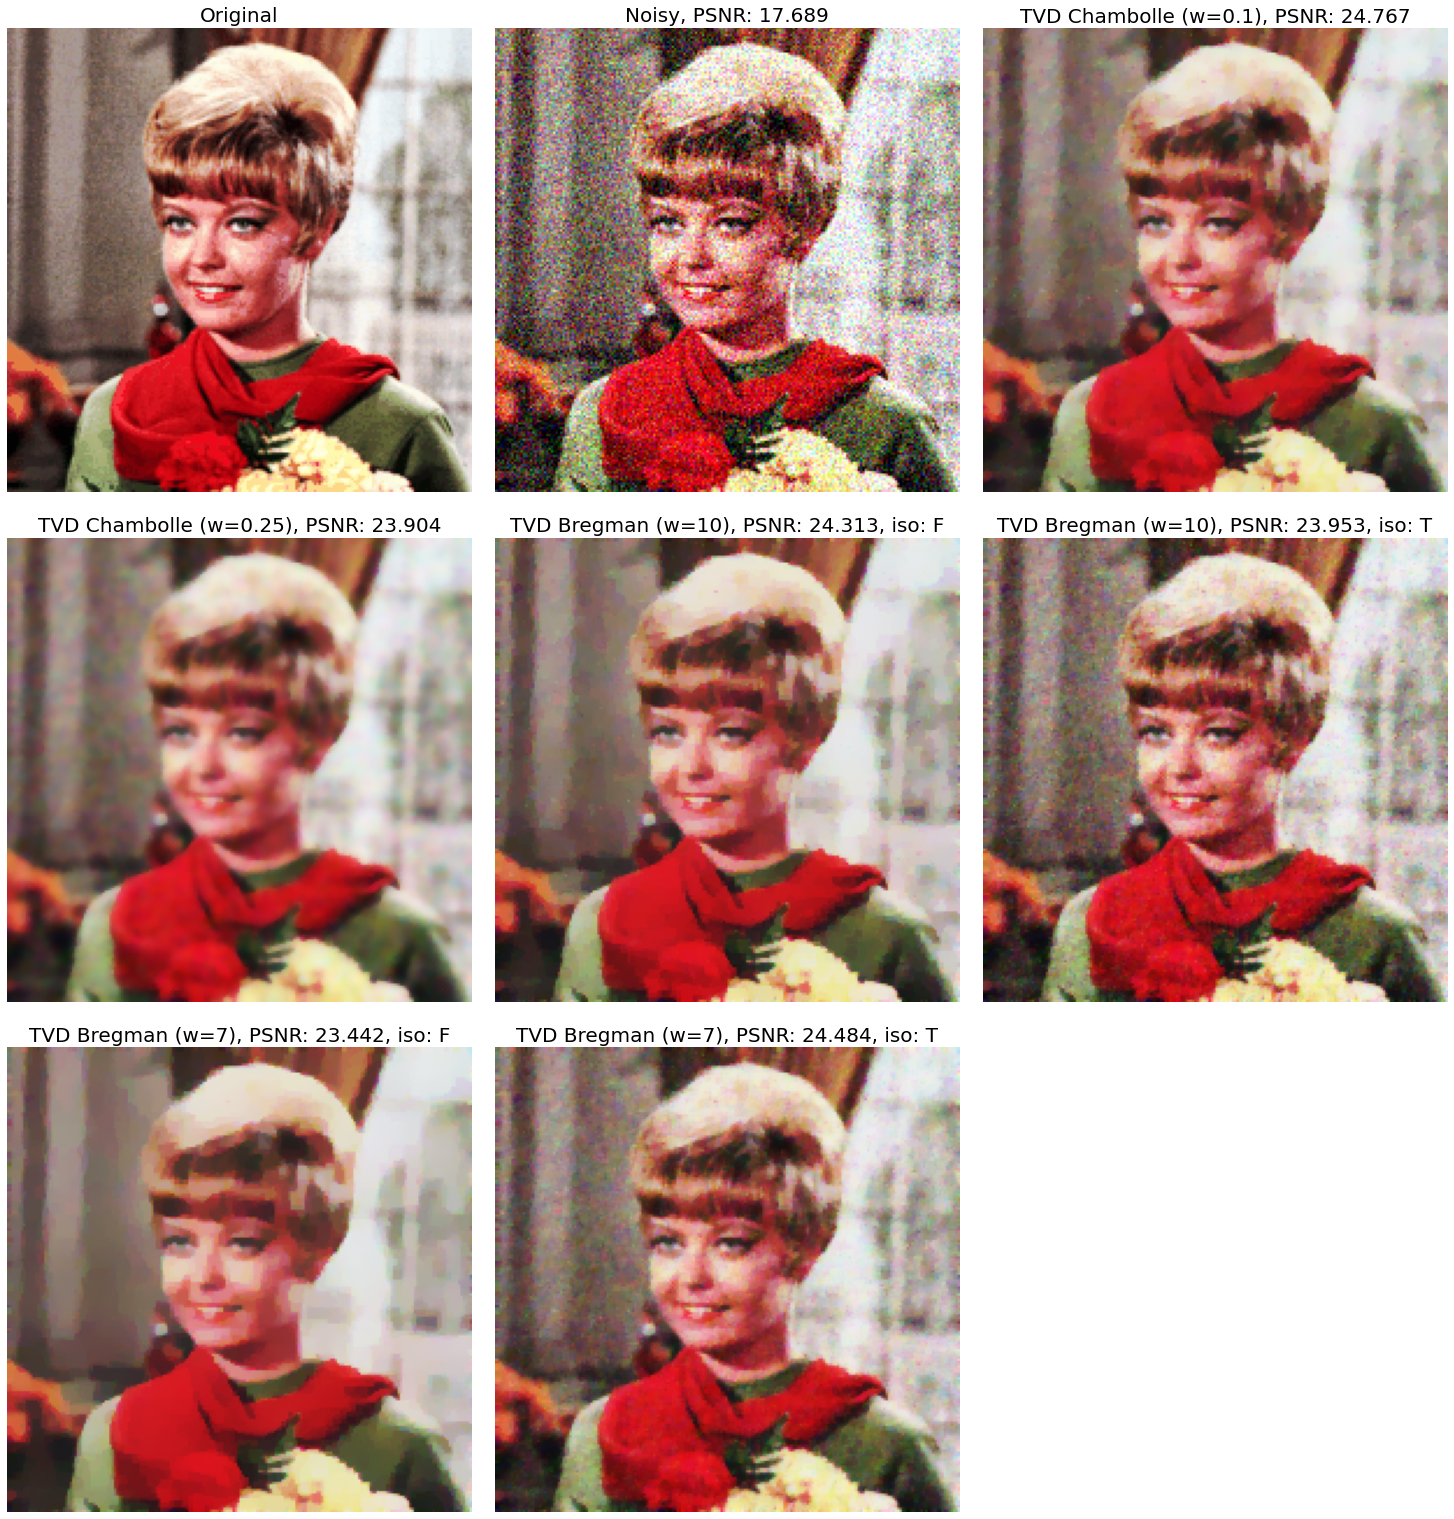

In [ ]:
def plot_image(img, title):
    plt.imshow(img), plt.axis('off'), plt.title(title, size=20)
    
plt.figure(figsize=(20,22))
plt.subplot(331), plot_image(img, 'Original')
plt.subplot(332), plot_image(noisy, 'Noisy, PSNR: {}'.format(np.round(psnr(img, noisy),3)))
i = 3
for weight in [0.1, 0.25]:
    tvd_out = denoise_tv_chambolle(noisy, weight=weight, multichannel=True)
    plt.subplot(3,3,i)
    plot_image(tvd_out, 'TVD Chambolle (w={}), PSNR: {}'.format(weight, np.round(psnr(img, tvd_out),3)))
    i += 1
for weight in [10, 7]:
    for isotropic in [False, True]:
        tvd_out = denoise_tv_bregman(noisy, weight=weight, isotropic=isotropic, multichannel=True)
        plt.subplot(3,3,i)
        plot_image(tvd_out, 'TVD Bregman (w={}), PSNR: {}, iso: {}'.format(weight, \
                            np.round(psnr(img, tvd_out),3), str(isotropic)[0]))
        i += 1
plt.subplots_adjust(wspace=0.05, hspace=0.05, top=0.95, bottom=0, left=0, right=1)
plt.show()

### Problem 6: Image Denoising with Wavelets

### 6.1: Wavelet-denoising with pywt

In [82]:
import pywt
#pywt.wavelist()

In [83]:
noise_sigma = 0.1
im = rgb2gray(imread('images/Img_01_16.jpg'))
noisy = im + np.random.normal(0, noise_sigma, size=im.shape)

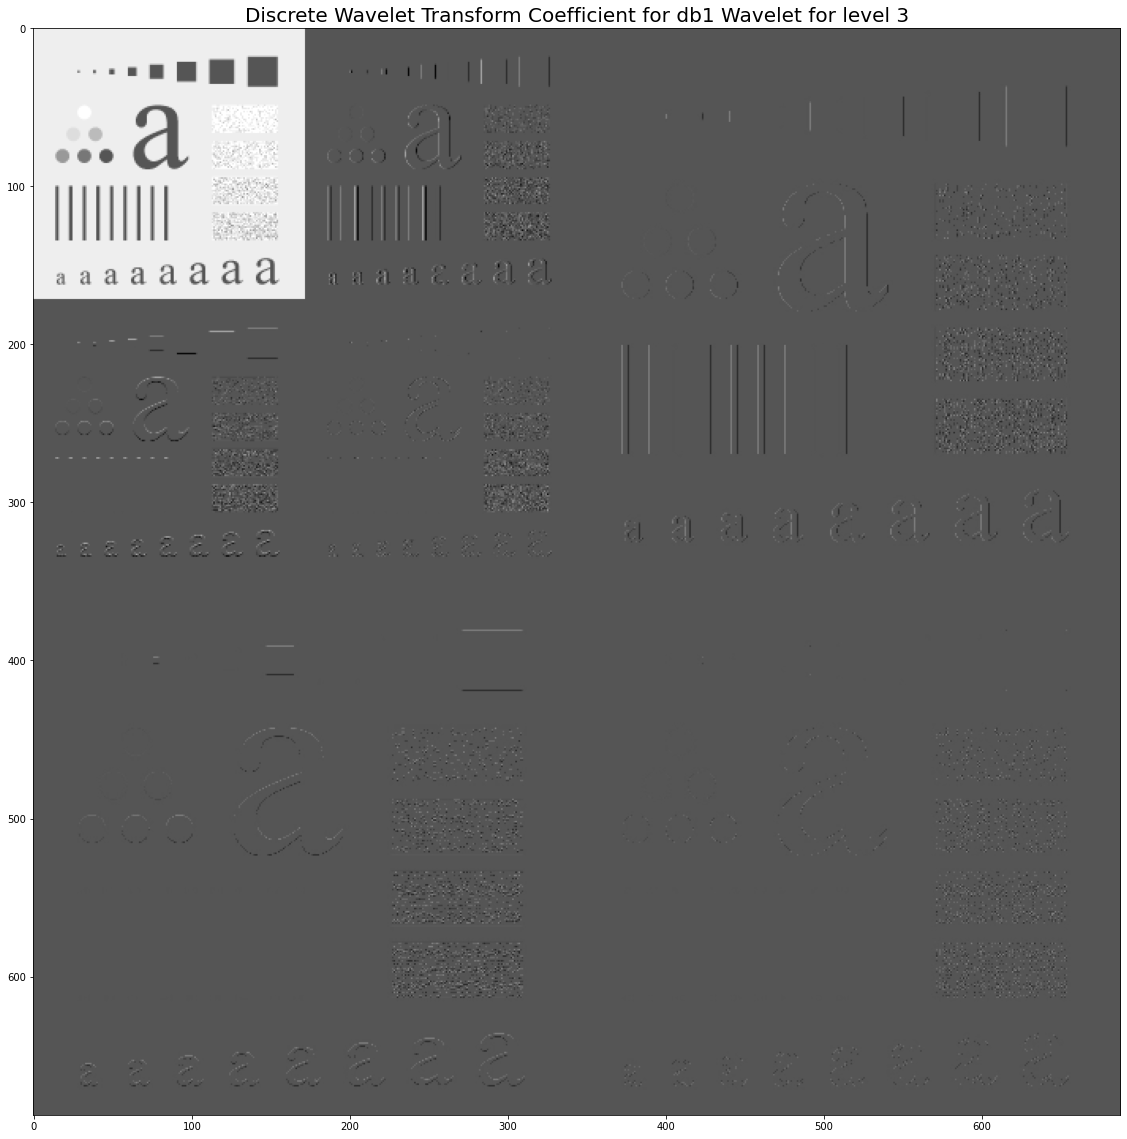

In [84]:
levels = 2
wavelet = 'db1'
coeffs = pywt.wavedecn(im, wavelet=wavelet, level=levels) 
arr, _ = pywt.coeffs_to_array(coeffs)
plt.figure(figsize=(20,20))
plt.imshow(arr, cmap='gray')
plt.title('Discrete Wavelet Transform Coefficient for db1 Wavelet for level 3', size=20)
plt.show()

![](images/Img_01_38.png)

In [88]:
def denoise(img, wavelet, noise_sigma, mode='soft'):
    levels = int(np.floor(np.log2(img.shape[0])))
    coeffs = pywt.wavedecn(img, wavelet, level=3) #levels) 
    threshold = noise_sigma*np.sqrt(2*np.log2(img.size))
    denoised_detail = [{key: pywt.threshold(level[key], value=threshold, mode=mode) for key in level} for level in coeffs[1:]]
    denoised_root = pywt.threshold(coeffs[0], value=threshold, mode=mode)
    denoised_coeffs = [denoised_root] + [d for d in denoised_detail]
    out = pywt.waverecn(denoised_coeffs, wavelet)
    return out

im = rgb2gray(imread('images/Img_01_17.jpg'))
noisy = im + np.random.normal(0, noise_sigma, size=im.shape)
im_denoised_haar = denoise(noisy, wavelet='haar', noise_sigma=noise_sigma)
im_denoised_haar_hard = denoise(noisy, wavelet='haar', noise_sigma=noise_sigma, mode='hard')
im_denoised_db6 = denoise(noisy, wavelet='db6', noise_sigma=noise_sigma)

![](images/wavelet_out.png)

### 6.2: Wavelet-denoising with scikit-image

In [ ]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)

In [ ]:
original = img_as_float(imread('images/Img_01_18.jpg'))
sigma = 0.12
noisy = random_noise(original, var=sigma**2)
sigma_est = estimate_sigma(noisy, average_sigmas=True, multichannel=True)
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

im_bayes = denoise_wavelet(noisy, convert2ycbcr=True, method='BayesShrink', mode='soft', rescale_sigma=True, multichannel=True)
psnr_noisy, psnr_bayes = psnr(original, noisy), psnr(original, im_bayes)

for sigma in [sigma_est/2, sigma_est/3, sigma_est/4]:
    im_visushrink = denoise_wavelet(noisy, convert2ycbcr=True, method='VisuShrink', mode='soft', \
                                    sigma=sigma, rescale_sigma=True, multichannel=True)
    psnr_visushrink = psnr(original, im_visushrink)
    # plot the output here

Estimated Gaussian noise standard deviation = 0.1208983266753569


![](images/wavelet_cat_out.png)

### Problem 7: Denoising using Non-local Means with opencv-python

In [81]:
img = cv2.imread('images/Img_01_02.jpg')
noisy = img + cv2.randn(np.copy(img), (0,0,0),(10,10,10))

In [79]:
for sz in [15, 21]:
    for h in [7, 10, 15]:
        start = time()
        dst = cv2.fastNlMeansDenoisingColored(noisy, None, templateWindowSize=12, searchWindowSize=sz, h=h, hColor=10)
        end = time()
        # plot the denoised output image here

![](images/nl_out.png)

### Problem 8: Denoising with Bilateral Filter

### 8.1:  with SimpleITK

In [ ]:
import SimpleITK as sitk

def show_image(img, title=None):
    nda = sitk.GetArrayViewFromImage(img)
    plt.imshow(nda, cmap='gray'), plt.axis('off')
    if(title): plt.title(title, size=20)

img = sitk.ReadImage('images/Img_01_02.jpg', sitk.sitkUInt8)
sf = sitk.ShotNoiseImageFilter()
noisy = sf.Execute(img)
plt.figure(figsize=(20,17))
plt.subplot(331), show_image(img, 'original')
plt.subplot(332), show_image(noisy, 'noisy')
i = 3
f = sitk.BilateralImageFilter()
for σ_d in [5, 10]:
    for σ_r in [25, 50, 75]:
        f.SetDomainSigma(σ_d)
        f.SetRangeSigma(σ_r)
        denoised = f.Execute(noisy)
        plt.subplot(3,3,i), show_image(denoised, 'denoised (σ_d={}, σ_r={})'.format(σ_d, σ_r))
        i += 1
plt.tight_layout()
plt.show()

### 8.2: with opencv-python

In [ ]:
img = cv2.imread('images/Img_01_02.jpg')
noisy = img + cv2.randn(np.copy(img), (0,0,0), (10,10,10))

for d in [9, 15]:
    for σ_c in [75, 180]:
        for σ_s in [75, 180]:
            dst = cv2.bilateralFilter(noisy,d=d,sigmaColor=σ_c,sigmaSpace=σ_s)
            # plot the output here

![](images/bilat_out.png)

### Problem 9: Denoising with MAP Bayesian with an MRF Prior

In **Bayesian image denoising** the *optimal noiseless image* is defined as the image that *maximizes* the **posterior pdf**. In this problem we shall implement a *maximum a-posteriori* (**MAP**) *Bayesian denoising algorithm* that uses a noise model coupled with *MRF prior* that uses a $4$-neighborhood system (hence satisfies the **Markov property**, since a pixel is dependent only on its *immediate neighbors*). The following figure shows the theory that will be required to implement the denoising algorithm [22].
    
![](images/Img_01_45.png)

* Let's start by importing the required libraries.

In [2]:
from scipy.optimize import minimize

In [ ]:
def g(u):
    return np.sum(u**2)

def grad_g(u):
    return 2*u

def compute_grad(X,Y,alpha):
    X, Y = X.reshape(im_size), Y.reshape(im_size)
    X1, X2, X3, X4 = np.roll(X, -1, 0), np.roll(X, 1, 0), np.roll(X, -1, 1), np.roll(X, 1, 1)
    grad = alpha*grad_g(X-Y) + grad_g((X-X1) + (X-X2) + (X-X3) + (X-X4))
    return grad.ravel()

def compute_obj_fun(X,Y,alpha):
    X, Y = X.reshape(im_size), Y.reshape(im_size)
    X1, X2, X3, X4 = np.roll(X, -1, 0), np.roll(X, 1, 0), np.roll(X, -1, 1), np.roll(X, 1, 1)
    loss =  alpha*g(X-Y) + g(X-X1) + g(X-X2) + g(X-X3) + g(X-X4)
    return loss

In [4]:
original = cv2.imread('images/Img_01_08.png', 0)
original = original / original.max()
noisy = random_noise(original, mode='s&p')
denoised = np.zeros_like(noisy)
im_size, alpha = original.shape, 1.5

![](images/denoise_MAP_out_init.png)

In [ ]:
res = minimize(func=compute_obj_fun, x0=denoised.ravel(), jac=compute_grad, method='L-BFGS-B', 
               args=(noisy.ravel(), alpha), options={'maxiter':4, 'gtol':0.1, 'disp': True})
#print(res)

* Retrieve the solution obtained and reshape it back into output image.
* Plot the denoised output image along with the difference image, compute the *PSNR*. The final output should be one as shown below.

In [ ]:
denoised = res.x.reshape(im_size)

![](images/denoise_MAP_out.png)

### Problem 10: Denoising Images with Kernel PCA

*Kernel PCA* (**kPCA**) is an extension of *Principal Component Analysis* (**PCA**) - a very popular *linear* dimension reduction technique. *kPCA* uses kernels to achieve non-linearity in dimensionality reduction. 

In *kPCA* we choose a ${\displaystyle \Phi }$ function which can be used to (conceptually) map to a very high-dimensional *feature space*, without the need for the data to be actually evaluated in that space. It's done by computing the *kernel* ${\displaystyle K=k(\mathbf {x} ,\mathbf {y} )=(\Phi (\mathbf {x} ),\Phi (\mathbf {y} ))=\Phi (\mathbf {x} )^{T}\Phi (\mathbf {y} )}$, representing the inner product space of the otherwise intractable feature space [21]. Using the *dual form* the *kPCA* never actually computes the *eigenvectors* (the **principal components**) and *eigenvalues* of the *covariance matrix* in the ${\displaystyle \Phi (\mathbf {x} )}$-space, instead it uses the **Kernel trick** to compute the *projections* of the data onto the *principal components*, as shown in the next figure. 

![](images/Img_01_44.png)

* While in *PCA* the number of components is bounded by the number of features, in *kPCA* the *number of components* is bounded by the *number of samples* (since it works in the *dual space*). Many real-world datasets have large number of samples and hence often finding all the components with a full *kPCA* is a waste of computation time, as data is mostly described by the first few components (e.g. `n_components` $\leq 100$). 

In this problem you will learn how to use `scikit-learn`'s `decomposition` module's `KernelPCA` implementation, to denoise degraded *MNIST* images (of handwritten digits). The idea will be to learn a PCA basis (with and without a kernel) on noisy images and then use these models to reconstruct and denoise these images.

* Let's start by importing the required libraries and modules, using the follosing ccode snippet.

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA

In [ ]:
df = pd.read_csv('images/mnist_train.csv')
df.head()

label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...    28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...        0      0   
1      0    0    0    0    0    0    0    0    0    0  ...        0      0   
2      4    0    0    0    0    0    0    0    0    0  ...        0      0   
3      1    0    0    0    0    0    0    0    0    0  ...        0      0   
4      9    0    0    0    0    0    0    0    0    0  ...        0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]

In [ ]:
y = np.array(df.label.tolist())
X = df.drop(columns=['label']).values
X = MinMaxScaler().fit_transform(X)
X.shape, y.shape

((60000, 784), (60000,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0, train_size=1_000, test_size=100)
rng = np.random.RandomState(0)
noise = rng.normal(scale=0.25, size=X_test.shape)
X_test_noisy = X_test + noise
noise = rng.normal(scale=0.25, size=X_train.shape)
X_train_noisy = X_train + noise

In [ ]:
pca = PCA(n_components=30)
kernel_pca = KernelPCA(n_components=400, kernel="rbf", gamma=1e-3, fit_inverse_transform=True, alpha=5e-3)
pca.fit(X_train_noisy)
_ = kernel_pca.fit(X_train_noisy)
pca.n_features_in_, kernel_pca.n_features_in_

(784, 784)

In [ ]:
X_reconstructed_kernel_pca = kernel_pca.inverse_transform(kernel_pca.transform(X_test_noisy))
X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test_noisy))

![](images/kpca_out.png)

## Questions

1. Prove that the solution to the optimization (minimization) problem with the loss function  
   
   $$loss_{Ridge} = (g−Af)^T(g-Af) + \alpha f^T f $$
   
   is given by the following normal equation:

   $$f=(A^TA + \alpha I)^{-1}A^Tg$$
    
2. Rather than using the normal equations to solve inverse problems, numerical analysis suggests that it is preferable to solve the augmented equations, as shown in the following figure, which can be done by a least squares solver (lsqr). Compare the performance to the one you used in problem 0, in terms of number of iterations required to achieve convergence.

![](images/Img_01_23.png)

3. Sum of absolute deviations is minimum when it's taken from median: Let's $S=\{X_1,X_2,\ldots,X_n\}$ be a set of numbers s.t., $X_1\leq X_2 \leq \ldots \leq X_n$. Prove that $\sum\limits_{k=1}^{n}|X_k-\theta|$ is minimum when $\theta=median(S)$.

5. Start with the noisy beans image, Visualize how the DWT coefficients change when thresholded with different threshold values, along with the change in PSNR of the denoised image, with hard / soft threshodling and find the thresholds corresponding to the peak PSNR values, you should get a figure that looks like the one shown below:
![](images/Img_01_19.png)

6. Use Savitzky–Golay filter (`scipy.signal.savgol_filter`) to denoise an image. Play with the window length and the polynomial -degree parameters to understand the impact on smoothing.

7. **Impact of noise on Inverse Filter**: Start with $G(u,v)=F(u,v)H(u,v)+N(u,v)$, where $N(u,v)$ is the frequency spectrum of the additive noise. Show that restoration with inverse filter gets impacted badly as the additive noise gets stronger (demonstrate with an example), can the Wiener filter get resolve the problem? 

8. Compare the restored images quality (e.g., with PSNR) obtained with the Wiener deconvolution implementations from `scipy.signal` and those obtained using the Wiener-Hunt deconvolution and its unsupervised version's implementations from  `skimage.restoration`.

9. Use `denoise_nl_means()` and `denoise_bilateral()` functions from `skimage.restoration` to apply non-local mean and bilateral denoising on a noisy image. Compare the results with those obtained using `opencv-python`.

10. Use the code for non-local means denoising implementation with `opencv-python` to visualize (in 3D) how the PSNR and the time taken to denoise varies with input parameters $h$ and $searchWindowSize$, you should obtain a figure like the following one.

    ![](images/Img_01_39.png)
  
    Try changing the value of the other parameters too, in roddr to observe the impact on the denoised image quality and the computational efficiency.

11. **Anisotropic diffusion**: Refer to the part 1 of this book (chapter 5) to implement the classic *Perona–Malik* algorithm to restore a degraded image and compare the output obtained with the other restoration methods.

12. Deep Inverse problems in python: implement deep image reconstruction with the python package *DeepInPy*, as discussed in  https://www1.icsi.berkeley.edu/~stellayu/publication/doc/2020deepInPyISMRM.pdf